
# Procesamiento y análisis de información textual

## @author: Adonis González

### Index del nb

1. **Obtención de datos a partir de información textual**: Búsqueda de términos unipalabra, colocaciones y vectorizaciones de términos.
2. **Obtención de datos a partir de recursos externos al texto**: Similitud de significado con Wordnet y ConceptNet.
3. **Interpretación de los datos**: Detectar temas.  
4. **Predicción**: Clasificación de textos.
   

## 1. Obtención de datos a partir de información textual

Primero, cargamos las librerías necesarias.


In [1]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import gensim
from sklearn.cluster import KMeans
import numpy as np
import os

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Utilizaremos el siguiente dataset ArticlesMarch2018.csv en el directorio /data. Si lo abrís veréis que tiene 15 campos.

El contenido principal:

<ul><b>Headline</b>: titulares</ul>
<ul><b>Snippet</b>: contenido de las noticias encabezadas por los titulares</ul>
<ul><b>Keywords</b>: palabras más relevantes de las noticias según sus redactores</ul>


## Preparación de los datos

In [2]:
# cargamos los paths necearios 
ROOT_DIR = os.path.abspath("../")
data_dir = os.path.join(ROOT_DIR, "data")

article_file = os.path.join(data_dir, "ArticlesMarch2018.csv")

In [3]:
#Transformamos el dataset en un dataframe

df= pd.read_csv(article_file)
df.head(1)

,articleID,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,5a974697410cf7000162e8a4,By BINYAMIN APPELBAUM,article,"Virtual Coins, Real Resources","['Bitcoin (Currency)', 'Electric Light and Pow...",1,Business,1,2018-03-01 00:17:22,Economy,America has a productivity problem. One explan...,The New York Times,News,https://www.nytimes.com/2018/02/28/business/ec...,1207


In [4]:
#Concatenemos los valores de los campos headline y snippet para 
#obtener un texto plano.
headline_texts = " ".join(df.headline.tolist()) #text plano
snippet_texts = " ".join(df.snippet.tolist()) #text plano

#Preparamos las keywords
keywords = []

todelete = ['[', ']', '\'']

for l in df.keywords.tolist():
    for td in todelete:
        l = l.lower().replace(td, '')
    keywords = keywords + l.split(', ')

print("========= KEYWORDS ========")
print(keywords[:10])

#Creamos un corpus a partir del cual haremos entrenamiento de modelos. 
#Es la unión de los textos del campo 
#headlines y los textos del campo snippets

sentences_for_modelling = df.headline.tolist() + df.headline.tolist() # lista


========= KEYWORDS ========
['bitcoin (currency)', 'electric light and power', 'united states economy', 'labor and jobs', 'productivity', 'united states defense and military forces', 'north korea', 'united states international relations', 'united states politics and government', 'embargoes and sanctions']


## 1.1 Encontramos términos unipalabra

Consideramos términos unipalabra a los tokens que empiezan y acaban con un caracter alfabético (e.g: 'casa' (SÍ), @casa (NO), casa26 (NO))</b>

In [5]:
import  re
from nltk import word_tokenize
from collections import Counter
nltk.download('punkt')
tokens_headline = [w for w in word_tokenize(headline_texts.lower()) if re.match("^[a-z]+.*", w)]
tokens_headline = [w for w in tokens_headline if w not in stopwords]

tokens_snippet = [w for w in word_tokenize(snippet_texts.lower()) if re.match("^[a-z]+.*", w)]
tokens_snippet = [w for w in tokens_snippet if w not in stopwords]

# en caso de ser los términos más comunes de headlines o snippet
# usamos el método most_common()

# hundred_headlines = Counter(tokens_headline).most_common(100)
# hundred_snippet = Counter(tokens_snippet).most_common(100)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# imprimimos 100 tokens de headline
print(tokens_headline[:100])

['virtual', 'coins', 'real', 'resources', 'u.s.', 'advances', 'military', 'plans', 'north', 'korea', 'mr.', 'trump', 'bad', 'judge', 'erase', 'dissent', 'china', 'bans', 'pooh', 'bear', 'n', 'loans', 'flowed', 'kushner', 'cos.', 'visits', 'white', 'house', 'china', 'envoy', 'intends', 'ease', 'trade', 'tensions', 'president', 'trump', 'contradictory', 'sometimes', 'false', 'comments', 'gun', 'policy', 'lawmakers', 'classic', 'letter', 'puzzle', 'silicon', 'valley', 'disruption', 'australian', 'school', 'assassination', 'gianni', 'versace', 'episode', 'nothing', 'man', 'graduate', 'trevor', 'noah', 'stunned', 'trump', 'turnabout', 'gun', 'control', 'black', 'panther', 'defining', 'moment', 'united', 'states', 'particularly', 'black', 'america', 'unknown', 'pension', 'pensionize', 'savings', 'goodbye', 'pay-as-you-wish', 'u.s.', 'closes', 'door', 'christians', 'fled', 'iran', 'gang', 'fearsome', 'reputation', 'inflated', 'president', 'trial', 'killer', 'widow', 'scared', 'victim', 'abuse

In [7]:
#imprimimos 100 tokens de snippet
print(tokens_snippet[:100])

['america', 'productivity', 'problem', 'one', 'explanation', 'may', 'growing', 'use', 'real', 'resources', 'make', 'virtual', 'products', 'american', 'military', 'looking', 'everything', 'troop', 'rotations', 'surveillance', 'casualty', 'evacuations', 'ordered', 'take', 'action', 'north', 'korea', 'guess', 'man', 'model', 'public', 'servant', 'censors', 'swung', 'action', 'mr.', 'xi', 'bid', 'become', 'leader', 'life', 'resurrected', 'memories', 'mao', 'personality', 'cult', 'feverish', 'emotions', 'created', 'apollo', 'private', 'equity', 'firm', 'citigroup', 'made', 'large', 'loans', 'last', 'year', 'family', 'real', 'estate', 'business', 'jared', 'kushner', 'president', 'trump', 'senior', 'adviser', 'china', 'sent', 'top', 'economic', 'adviser', 'united', 'states', 'restore', 'dialogue', 'quash', 'trade', 'war', 'faces', 'long', 'odds', 'president', 'mixed', 'facts', 'falsehoods', 'discussing', 'gun', 'policy', 'potential', 'solutions', 'legislators', 'timothy', 'polin', 'gives', 'u

In [8]:
# common = []
# for i in tokens_headline:
#     if i in tokens_snippet:
#         common.append(i)
# a, b, c = len(tokens_headline), len(tokens_snippet), len(common)
# res = c * 100 / (a + b )
# print("Porcentaje de terminos unipalabra", res)

# usamos el método intersection para calcular el porcentaje de términos
# unipalabras que aparecen en el campo snippet y headline.
num_snipets = set(tokens_snippet)
num_headline = set(tokens_headline)
result = num_snipets.intersection(num_headline)
result = len(result)/ len(num_snipets)
print("Porcentaje de términos unipalabra", result*100)

Porcentaje de términos unipalabra 31.109051590979302


### Conclusiones

- Se podría extraer conclusiones pero serían demasiado simples, se debería considerar más términos si se quiere obtener mejores resultados y conclusiones.

- Añadiremos la palabra "us" ya que además de ser pronombre "nosotros" podría causar controversia con "u.s." por lo que las añadiría a la lista de stopwords esta palabra.

- La palabra unknown también puede confundirse con un adjetivo/nombre pero parece que corresponde una entrada deconocido en el dataset.


In [9]:
# añadimos a la lista unknown
stopwords.append('unknown')

## 1.2 Encontramos colocaciones

Calcularemos las colocaciones más relevantes de los <b>snippets</b> según las métricas: <b>PMI</b> y <b>Likehood Ratio</b>

Para este apartado, habrá que cargar las librerías siguientes:

In [10]:
from nltk import pos_tag, word_tokenize
from nltk.collocations import *
import re

In [11]:
help(nltk.collocations.BigramAssocMeasures)

Help on class BigramAssocMeasures in module nltk.metrics.association:

class BigramAssocMeasures(NgramAssocMeasures)
 |  A collection of bigram association measures. Each association measure
 |  is provided as a function with three arguments::
 |  
 |      bigram_score_fn(n_ii, (n_ix, n_xi), n_xx)
 |  
 |  The arguments constitute the marginals of a contingency table, counting
 |  the occurrences of particular events in a corpus. The letter i in the
 |  suffix refers to the appearance of the word in question, while x indicates
 |  the appearance of any word. Thus, for example:
 |  
 |      n_ii counts (w1, w2), i.e. the bigram being scored
 |      n_ix counts (w1, *)
 |      n_xi counts (*, w2)
 |      n_xx counts (*, *), i.e. any bigram
 |  
 |  This may be shown with respect to a contingency table::
 |  
 |              w1    ~w1
 |           ------ ------
 |       w2 | n_ii | n_oi | = n_xi
 |           ------ ------
 |      ~w2 | n_io | n_oo |
 |           ------ ------
 |          

Computamos los mil mejores bigramas y trigramas a partir de los términos unipalabra.

In [12]:
from nltk import word_tokenize
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [13]:
# se definen las funciones a usar, para dar respuesta tanto a los bigramas como a los 
# trigramas, se usa la medida PMI para obtener los mejores bi/tri gramas.

def get_coll_candidates(tokens):
    bigramcandidates = BigramCollocationFinder.from_words(tokens)
    trigramcandidates = TrigramCollocationFinder.from_words(tokens)
    return bigramcandidates , trigramcandidates

def re_filter_candidates(bigram_coll_candidates, trigram_coll_candidates):
    bigram_coll_candidates.apply_word_filter(lambda w: (re.match(r'\W', w)))
    trigram_coll_candidates.apply_word_filter(lambda w: (re.match(r'\W',w)))
    return bigram_coll_candidates, trigram_coll_candidates

def get_n_best_candidates_pmi(bigram_candidates, trigram_candidates, n_best_collocations):
    nbest_bigram_candidates = bigram_candidates.nbest(bigram_measures.pmi,n_best_collocations)
    nbest_trigram_candidates = trigram_candidates.nbest(trigram_measures.pmi,n_best_collocations)
    return nbest_bigram_candidates, nbest_trigram_candidates

def get_best_big_trig_pmi(text, n_best_collocations):
    tokens = text
    bigram_coll_candidates, trigram_coll_candidates = get_coll_candidates(tokens)
    bigram_coll_candidates_filtered, trigram_coll_candidates_filtered = re_filter_candidates(bigram_coll_candidates, 
                                                                                            trigram_coll_candidates)    
    
    best_bigrams_cand, best_trigrams_cand = get_n_best_candidates_pmi(bigram_coll_candidates_filtered, 
                                                                 trigram_coll_candidates_filtered,
                                                                 n_best_collocations)
    return best_bigrams_cand, best_trigrams_cand

In [14]:
# como se comentó la función devuelve dos lista, para los bi/tri gramas
# son una listas de tuplas con los valores, se pasa por parametro los 1000 
# para obtener esta candidad de nbest.
best_bigrams, best_trigrams = get_best_big_trig_pmi(tokens_snippet, 1000)

In [15]:
# se imprimen los 1000 mejores bigramas (se entiende que se tiene que imprimir aunque
# el documento resultante del jupyter N. pueda quedar extenso)

print("num bigrams", len(best_bigrams))
print(best_bigrams)

num bigrams 1000
[('a.r', 'gurney'), ('abbey', 'trappist'), ('abdel', 'fattah'), ('abe', 'cultivated'), ('abloh', 'louis'), ('abusive', 'harassing'), ('accepting', 'bribes'), ('accessible', 'cogent'), ('accounts', 'fake'), ('accusations', 'forthcoming'), ('acknowledge', 'sexting'), ('activity', 'picking'), ('adapted', 'distinguish'), ('add', 'springlike'), ('adhiambo', 'mitchell'), ('adjustment', 'period.'), ('admitted', 'bear'), ('adoption', 'day.'), ('adults', 'inaction'), ('adventure', 'meandering'), ('adversaries', 'eventually'), ('adélie', 'penguins'), ('african-americans', 'heroin'), ('agriculture', 'preventive'), ('aid', 'environment'), ('ailing', 'gianni'), ('aiming', 'roll'), ('aired', 'o.j'), ('airline', 'emphasizing'), ('alan', 'hollinghurst'), ('albert', 'kahn'), ('alberto', 'carvalho'), ('alejandro', 'jodorowsky'), ('alexa', 'katie'), ('alexander', 'nix'), ('allergies', 'eczema'), ('alluring', 'seasonless'), ('aloof', 'uninspiring'), ('amassed', 'autographs'), ('amsterdam'

In [16]:
print("num bigrams", len(best_trigrams))
print(best_trigrams)

num bigrams 1000
[('abdel', 'fattah', 'el-sisi'), ('abloh', 'louis', 'vuitton'), ('accounts', 'fake', 'made-for-television'), ('acknowledge', 'sexting', 'aspect'), ('adapted', 'distinguish', 'retailers'), ('add', 'springlike', 'crunch'), ('adoption', 'day.', 'megachurches'), ('adversaries', 'eventually', 'tire'), ('african-americans', 'heroin', 'cruise'), ('ailing', 'gianni', 'versace'), ('aired', 'o.j', 'simpson'), ('airline', 'emphasizing', 'in-flight'), ('albert', 'kahn', 'endure'), ('alberto', 'carvalho', 'renounced'), ('amassed', 'autographs', 'dating'), ('amsterdam', 'explores', 'fascination'), ('andrea', 'carla', 'michaels'), ('angela', 'merkel', 'pledged'), ('ann', 'arbor', 'renovated'), ('anti-anxiety', 'sleep', 'medications'), ('arnaud', 'beltrame', 'traded'), ('asylum', 'seekers', 'crossing'), ('au', 'haut', 'maine'), ('b.m.i', 'dust', 'settled'), ('backhand', 'uncorking', 'swirling'), ('barbara', 'haskell', 'marks'), ('baths', 'judges', 'appoint'), ('beans', 'oxtail', 'plan

Computamos los mil mejores bigramas y trigramas a partir de los términos unipalabra, pero con la <b>Likehood Ratio</b>

In [17]:
# se modifica la funcion para obtener los mejores bi/tri gramas pero usando la medida
# likelihood,  los métodos devuelven igual que en el apartado anterior dos listas.

def get_n_best_candidates_lkr(bigram_candidates, trigram_candidates, n_best_collocations):
    nbest_bigram_candidates = bigram_candidates.nbest(bigram_measures.likelihood_ratio,n_best_collocations)
    nbest_trigram_candidates = trigram_candidates.nbest(trigram_measures.likelihood_ratio,n_best_collocations)
    return nbest_bigram_candidates, nbest_trigram_candidates

def get_best_big_trig_likr(text, n_best_collocations):
    tokens = text
    bigram_coll_candidates, trigram_coll_candidates = get_coll_candidates(tokens)
    bigram_coll_candidates_filtered, trigram_coll_candidates_filtered = re_filter_candidates(bigram_coll_candidates, 
                                                                                            trigram_coll_candidates)    
    
    best_bigrams_cand, best_trigrams_cand = get_n_best_candidates_lkr(bigram_coll_candidates_filtered, 
                                                                 trigram_coll_candidates_filtered,
                                                                 n_best_collocations)
    return best_bigrams_cand, best_trigrams_cand

In [18]:
# se obtiene resultado para los 1000 mejores bi/tri gramas pero usando la medida
# likehood
best_bigrams_lkr, best_trigrams_lkr = get_best_big_trig_likr(tokens_snippet, 1000) 

In [19]:
print(best_bigrams_lkr)

[('new', 'york'), ('united', 'states'), ('president', 'trump'), ('white', 'house'), ('prime', 'minister'), ('york', 'times'), ('cambridge', 'analytica'), ('steel', 'aluminum'), ('york', 'city'), ('special', 'counsel'), ('kim', 'jong-un'), ('chief', 'executive'), ('north', 'korea'), ('attorney', 'general'), ('de', 'blasio'), ('last', 'year'), ('social', 'media'), ('gun', 'control'), ('m.', 'cuomo'), ('conor', 'lamb'), ('trump', 'administration'), ('last', 'week'), ('residential', 'sales'), ('join', 'moderated'), ('moderated', 'conversation'), ('mr.', 'trump'), ('years', 'ago'), ('andrew', 'm.'), ('revealed', 'entries'), ('silicon', 'valley'), ('stripped', 'caption'), ('gov', 'andrew'), ('san', 'francisco'), ('metoo', 'movement'), ('caption', 'join'), ('recent', 'residential'), ('supreme', 'court'), ('mark', 'zuckerberg'), ('week', 'properties'), ('times', 'crossword'), ('parkland', 'fla.'), ('image', 'tell'), ('andrew', 'cunanan'), ('high', 'school'), ('look', 'closely'), ('cox', 'henry

In [20]:
print(best_trigrams_lkr)

[('new', 'york', 'times'), ('new', 'york', 'city'), ('sales', 'new', 'york'), ('obituaries', 'new', 'york'), ('makes', 'new', 'york'), ('spoke', 'new', 'york'), ('brewery', 'new', 'york'), ('closure', 'new', 'york'), ('dive', 'new', 'york'), ('edit', 'new', 'york'), ('fables', 'new', 'york'), ('it.', 'new', 'york'), ('new', 'york', 'academy'), ('new', 'york', 'angels'), ('new', 'york', 'edit'), ('profile', 'new', 'york'), ('unprotected', 'new', 'york'), ('new', 'york', 'places'), ('passengers', 'new', 'york'), ('solo', 'new', 'york'), ('new', 'york', 'retrospective'), ('assignment', 'new', 'york'), ('felt', 'new', 'york'), ('new', 'york', 'fed'), ('obtained', 'new', 'york'), ('entries', 'new', 'york'), ('hollywood', 'new', 'york'), ('new', 'york', 'period'), ('seen', 'new', 'york'), ('new', 'york', 'beyond'), ('streets', 'new', 'york'), ('toward', 'new', 'york'), ('one', 'new', 'york'), ('affair', 'president', 'trump'), ('governor', 'new', 'york'), ('new', 'york', 'state'), ('pennsylva

Calcularemos las colocaciones más relevantes de los <b>snippets</b> pero con el módulo <b>Phrases</b> de Gensim

Previamente cargaremos el módulo Phrases.

In [21]:
from gensim.models.phrases import Phrases
from gensim.models import Phrases

Preprocesamos el texto que utilizaremos para entrenar el modelo de detección de phrases. Al resultado le llamaremos <b><i>stream</i></b>. Como vimos en el apartado 3.3, el stream tiene que ser una lista de listas. Cada lista contiene los términos de una frase: e.g. [['virtual', 'coins', 'real', 'resources'],  ['u.s', 'advances', 'military', 'plans', 'for', 'north', 'korea'],  ['mr', 'trump', 'and', 'the', 'very', 'bad', 'judge']]

No queremos considerar la palabra <b>unknown</b>

In [22]:
# stream = [word_tokenize(d.lower()) for d in tokens_snippet if d != "Unknown"]

# Se entiende que se tiene que preprocesar convirtiendo la columna snippets a listas
stream = [word_tokenize(d.lower()) for d in df.snippet.tolist() if d != "Unknown"]
print(stream[:5])

[['america', 'has', 'a', 'productivity', 'problem', '.', 'one', 'explanation', 'may', 'be', 'the', 'growing', 'use', 'of', 'real', 'resources', 'to', 'make', 'virtual', 'products', '.'], ['the', 'american', 'military', 'is', 'looking', 'at', 'everything', 'from', 'troop', 'rotations', 'to', 'surveillance', 'to', 'casualty', 'evacuations', 'should', 'it', 'be', 'ordered', 'to', 'take', 'action', 'against', 'north', 'korea', '.'], ['can', 'you', 'guess', 'which', 'man', 'is', 'the', 'model', 'public', 'servant', '?'], ['censors', 'swung', 'into', 'action', 'after', 'mr.', 'xi', '’', 's', 'bid', 'to', 'become', 'leader', 'for', 'life', 'resurrected', 'memories', 'of', 'mao', '’', 's', 'personality', 'cult', 'and', 'the', 'feverish', 'emotions', 'that', 'it', 'created', '.'], ['apollo', ',', 'the', 'private', 'equity', 'firm', ',', 'and', 'citigroup', 'made', 'large', 'loans', 'last', 'year', 'to', 'the', 'family', 'real', 'estate', 'business', 'of', 'jared', 'kushner', ',', 'president', '

<b>
Entrenamos el modelo para detectar phrases.
</b>

In [23]:
# phrases = Phrases(stream, min_count=1, threshold=2, delimiter=b'_')
phrases = Phrases(stream, min_count=1, threshold=2, delimiter=B' ')

Utilizamos el modelo para detectar las phrases de los snippets. Presentamos las phrases que contienen más de una palabra (el caracter delimitador de Phrases por defecto es '_')

In [24]:
doc_tokens = word_tokenize(snippet_texts)
text_phrases = phrases[doc_tokens]

print(text_phrases[:15])

['America', 'has', 'a', 'productivity', 'problem .', 'One', 'explanation', 'may be', 'the growing', 'use of', 'real', 'resources', 'to make', 'virtual', 'products']


<b>Evaluación de los métodos de extracción de colocaciones</b>

Compararamos los resultados de cada método (PMI, Log Likehood y Phrase) con las <b>Keywords</b>.

Primer paso: Encontramos la intersección entre la suma de bigramas y trigramas calculados con el método PMI y la lista de keywords

In [25]:
# a continuación se muestra los bigramas y trigramas con su respectivo score tanto 
# para pmi y likeh para proceder a comprar resultados.
bigram_coll_candidates, trigram_coll_candidates = get_coll_candidates(tokens_snippet)
bigram_coll_candidates_filtered, trigram_coll_candidates_filtered = re_filter_candidates(bigram_coll_candidates, 
                                                                                        trigram_coll_candidates)    

In [26]:
# def nbest(self, score_fn, n):
#     """Returns the top n ngrams when scored by the given function."""
#     return [p for p, s in self.score_ngrams(score_fn)[:n]]

#la definicion de la funcion devuelve n elementos de la lista

# se muestra los mejores bigrama con el score pmi
# bigram_coll_candidates_filtered.score_ngrams(bigram_measures.pmi)[:1000]
pd.DataFrame(list(bigram_coll_candidates_filtered.score_ngrams(bigram_measures.pmi)[:1000]), columns=['bigram','pmi'])

,bigram,pmi
0,"(a.r, gurney)",13.981478
1,"(abbey, trappist)",13.981478
2,"(abdel, fattah)",13.981478
3,"(abe, cultivated)",13.981478
4,"(abloh, louis)",13.981478
...,...,...
995,"(spouse, therapist)",13.981478
996,"(springlike, crunch)",13.981478
997,"(spry, winning)",13.981478
998,"(staffing, mistakes)",13.981478


In [27]:
# se muestra los mejores trigramas con el score pmi
# trigram_coll_candidates_filtered.score_ngrams(trigram_measures.pmi)[:1000]
pd.DataFrame(list(trigram_coll_candidates_filtered.score_ngrams(trigram_measures.pmi)[:1000]), columns=['trigram','pmi'])

,trigram,pmi
0,"(abdel, fattah, el-sisi)",27.962956
1,"(abloh, louis, vuitton)",27.962956
2,"(accounts, fake, made-for-television)",27.962956
3,"(acknowledge, sexting, aspect)",27.962956
4,"(adapted, distinguish, retailers)",27.962956
...,...,...
995,"(interconnected, delivering, immediate)",26.377994
996,"(isle, au, haut)",26.377994
997,"(jacqueline, kennedy, onassis)",26.377994
998,"(james, b., comey)",26.377994


In [28]:
#Se hace la union de los mejores 1000 bigramas y trigramas obtenidos con PMI
collocation_candidates = best_bigrams + best_trigrams
collocations = [" ".join(cc) for cc in collocation_candidates]
# print(collocations)

Encontramos la intersección entre la suma de bigramas y trigramas calculados con el método Log Likehood y la lista de keywords

In [29]:
# bigram_coll_candidates_filtered.score_ngrams(bigram_measures.likelihood_ratio)[:1000]
pd.DataFrame(list(bigram_coll_candidates_filtered.score_ngrams(bigram_measures.likelihood_ratio)[:1000]), columns=['bigram','lkr'])

,bigram,lkr
0,"(new, york)",431.906488
1,"(united, states)",416.698266
2,"(president, trump)",411.422648
3,"(white, house)",212.397242
4,"(prime, minister)",154.362692
...,...,...
995,"(martyna, majok)",21.382382
996,"(martyr, deferment)",21.382382
997,"(masquerading, superintendent.)",21.382382
998,"(massive, manufacturing)",21.382382


In [30]:
# trigram_coll_candidates_filtered.score_ngrams(trigram_measures.likelihood_ratio)[:1000]
pd.DataFrame(list(trigram_coll_candidates_filtered.score_ngrams(trigram_measures.likelihood_ratio)[:1000]), columns=['trigram','lkr'])

,trigram,lkr
0,"(new, york, times)",859.724936
1,"(new, york, city)",839.316024
2,"(sales, new, york)",729.264851
3,"(obituaries, new, york)",683.440035
4,"(makes, new, york)",678.509300
...,...,...
995,"(news, north, korean)",81.772889
996,"(men, women, served)",81.557156
997,"(testified, bill, de)",81.518175
998,"(border, wall, fifty)",81.499270


In [31]:
# se realiza la suma de los mejores bigramas y trigramas usando la medida likehood
collocation_candidates_lkr = best_bigrams_lkr + best_trigrams_lkr
collocations_lkr = [" ".join(cc) for cc in collocation_candidates_lkr]

### Conclusiones

- Los resultados de Phrase no se puede evaluar comparándolos con los resultados del método PMI y Log Likehood, la clase Phrases tiene un threshold que simplemente representa la puntuación de las frases, se acepta una frase si la puntuación es mayor que este umbral.


- Al parecer __Phrases__ es más adecuado para obtener resultados de colaciones ya que la interseccioón obtenida es mayor usando esta clase. Usando la medida Likehood también se obtienen mejores resultados si comparamos con los resultados obtenidos con la medida PMI.

## Métodos de extracción de colocaciones con <b>información lingüística</b>

Mejoramos la gramática  detectar n-gramas añadiendo otros patrones sintácticos, por ejemplo patrones que combinen adjetivos y nombres.

Recordemos la clasificación de etiquetas PoS.

<b>Etiquetas PoS</b>

<ul>
<li>DT: Determinante</li>
<li>JJ: Adjetivo</li>
<li>NN: Nombre en singular</li>
<li>NNS: Nombre en plural</li>
<li>VBD: Verbo en pasado</li>
<li>VBG: Verbo en gerundio</li>
<li>MD: Verbo modal</li>
<li>IN: Preposición</li>
<li>PRP: Pronombre</li>
<li>RB: Adverbio</li>
<li>CC: Conjunción coordinada</li>
<li>CD: Numeral</li>
</ul>

In [32]:
def patterns_and_parser():
#Definición de los patterns sintácticos de un nodo N. La hoja de un nodo N es un nombre en singular (NN) 
#o en plural (NNS)
    n_patterns = """
              N: {<NN>|<NNS>}
              """
#Definición de los patterns sintácticos de un nodo CN. Las hojas de un nodo CN son dos nombres en singular
    cn_patterns = """
              CN: {<NN> <NN>}
              """
#Definición de los patterns sintácticos de un nodo NV. Las hojas de un nodo NV es un nombre y un verbo en pasado
    nv_patterns = """
              NV: {<NN> <VBG>}
              """
#Definición del parser que creará los nodos N del árbol
    n_parser = nltk.RegexpParser(n_patterns)
#Definición del parser que creará los nodos CN del árbol    
    cn_parser = nltk.RegexpParser(cn_patterns)
#Definición del parser que creará los nodos NV del árbol    
    nv_parser = nltk.RegexpParser(nv_patterns)
    return n_patterns, cn_patterns, nv_patterns, n_parser, cn_parser, nv_parser

In [33]:
def get_string_form(tuple_list):
    words = [cti[0] for cti in tuple_list]
    string_form = "_".join(words)
    return string_form

In [34]:
def get_n_and_cn_nv(tagged_tokens):
    #Definición de patterns sintácticos y parser
    n_patterns, cn_patterns, nv_patterns, n_parser, cn_parser, nv_parser = patterns_and_parser()
    #Creación de los árboles con los nodos N
    n_tree = n_parser.parse(tagged_tokens)
    #Creación de los árboles con los nodos CN
    cn_tree = cn_parser.parse(tagged_tokens)
    #Creación de los árboles con los nodos nv
    nv_tree = nv_parser.parse(tagged_tokens)
    #Listado de las hojas de los nodos N
    n_leaves = [s.leaves() for s in n_tree.subtrees() if s.label() == 'N'] # Lista de hojas N. Una hoja es una lista
                                                                           # de tuplas (token, PoS)
                                                                           #(e.g: [[('philosophers', 'NNS')],...])
    #Listado de las hojas de los nodos CN
    cn_leaves = [s.leaves() for s in cn_tree.subtrees() if s.label() == 'CN'] # Lista de hojas CN
                                                                              # (e.g: [('world', 'NN'), 
                                                                              #        ('event', 'NN')],...])
        #Listado de las hojas de los nodos CN
    nv_leaves = [s.leaves() for s in nv_tree.subtrees() if s.label() == 'NV'] # Lista de hojas nv
                                                                              # (e.g: [('world', 'NV'), 
                                                                              #        ('event', 'NV')],...])
    #Unión de los dos listados
    n_cn_tuples = n_leaves + cn_leaves + nv_leaves  
    #Conversión de las tuplas que representan las hojas al término
    n_and_cn_nv = [get_string_form(c) for c in n_cn_tuples]#e.g: [('world', 'NN'), ('event', 'NN')] -> world_event                                                                       
    
    return n_and_cn_nv

### 1.3 Vectorizamos términos 

Entrenamos un modelo word2vec de los titulares con los snippets (text_for_modelling)

Primer paso: preprocesamos el texto que utilizaremos para entrenar el modelo.

In [35]:
# stream_w2 = [word_tokenize(d.lower()) for d in df.headline.tolist() if d != "Unknown"]
stream_w2 = [word_tokenize(d.lower()) for d in df.snippet.tolist() if d != "Unknown"]
print(stream_w2[:5])

[['america', 'has', 'a', 'productivity', 'problem', '.', 'one', 'explanation', 'may', 'be', 'the', 'growing', 'use', 'of', 'real', 'resources', 'to', 'make', 'virtual', 'products', '.'], ['the', 'american', 'military', 'is', 'looking', 'at', 'everything', 'from', 'troop', 'rotations', 'to', 'surveillance', 'to', 'casualty', 'evacuations', 'should', 'it', 'be', 'ordered', 'to', 'take', 'action', 'against', 'north', 'korea', '.'], ['can', 'you', 'guess', 'which', 'man', 'is', 'the', 'model', 'public', 'servant', '?'], ['censors', 'swung', 'into', 'action', 'after', 'mr.', 'xi', '’', 's', 'bid', 'to', 'become', 'leader', 'for', 'life', 'resurrected', 'memories', 'of', 'mao', '’', 's', 'personality', 'cult', 'and', 'the', 'feverish', 'emotions', 'that', 'it', 'created', '.'], ['apollo', ',', 'the', 'private', 'equity', 'firm', ',', 'and', 'citigroup', 'made', 'large', 'loans', 'last', 'year', 'to', 'the', 'family', 'real', 'estate', 'business', 'of', 'jared', 'kushner', ',', 'president', '

Entrenamos un modelo Word2Vec a partir del texto preprocesado. Recordemos que el paquete <b>gensim</b> implementa un método para entrenar modelos Word2Vec.

In [36]:
w2vnyt = gensim.models.Word2Vec(
        stream_w2,
        size=150, 
        window=10, 
        min_count= 3, 
        workers= 1,
        seed=1 
)
w2vnyt.train(stream_w2, total_examples=len(stream_w2), epochs=10)


(169391, 323480)

Mostramos los vectores de los términos según el modelo Word2Vec mediante TSNE

Cargamos los paquetes necesarios. Recuerda que tienes que obtener el vocabulario

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [38]:
# def tsne_plot(model):
#     labels, tokens = [], []
#     for word in model.wv.vocab:
#         tokens.append(model[word])
#         labels.append(word)
    
#     tsne_model = TSNE(n_components=2, random_state=1)
#     new_values = tsne_model.fit_transform(tokens)

#     x, y = [], []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
        
#     plt.figure(figsize=(16, 16)) 
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
#     plt.show()
# tsne_plot(w2vnyt)

In [39]:
def good_candidate(t,postag):
    v = False
    #Si es multipalabra
    if ' ' in t:
        tl = t.split(' ') #Generamos una lista de tokens
        #el token inicial y el token final deben ser alfabéticos y no pueden estar en la lista de stopwords..
        if re.match("^[a-z]+.*", tl[0]) and re.match("^[a-z]+.*", tl[-1]) and \
           tl[0] not in stopwords and tl[1] not in stopwords:
            #... ni su PoS puede estar en la lista no_pos_in
            if postag[0][1] not in no_pos_in and postag[-1][1] not in no_pos_in:
                v = True
    #Si es monopalabra
    else:
        #debe ser alfabético, y no estar en la lista de stopwords
        if t not in stopwords and re.match("^[a-z]+.*", t):
            #y su PoS no puede estar en la lista no_pos_in
            if postag[0][1] not in no_pos_in:
                v = True
    return v

In [40]:
phrases_vocabulary = list(w2vnyt.wv.vocab)
postag = {}
text_phrases_stripped = [tp.strip('".,;:-():!?-‘’ ') for tp in text_phrases]
for tps in text_phrases_stripped:
    postag[tps] = nltk.pos_tag(word_tokenize(tps))
    
def phrase_is_term(phrase):
    test = False
    if phrase not in postag:
        pos = nltk.pos_tag(word_tokenize(phrase))
    else:
        pos = postag[phrase]
    if good_candidate(phrase,pos):
        test = True
    return test

no_pos_in = ['DT', 'IN', 'PRP', 'CC', 'CD','MD', 'VBG', 'VBD', 'RP']
terms_vocabulary = [pv for pv in phrases_vocabulary if phrase_is_term(pv) == True]

<ipython-input-41-ecf1f6605428>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = w2vnyt[terms_vocabulary]


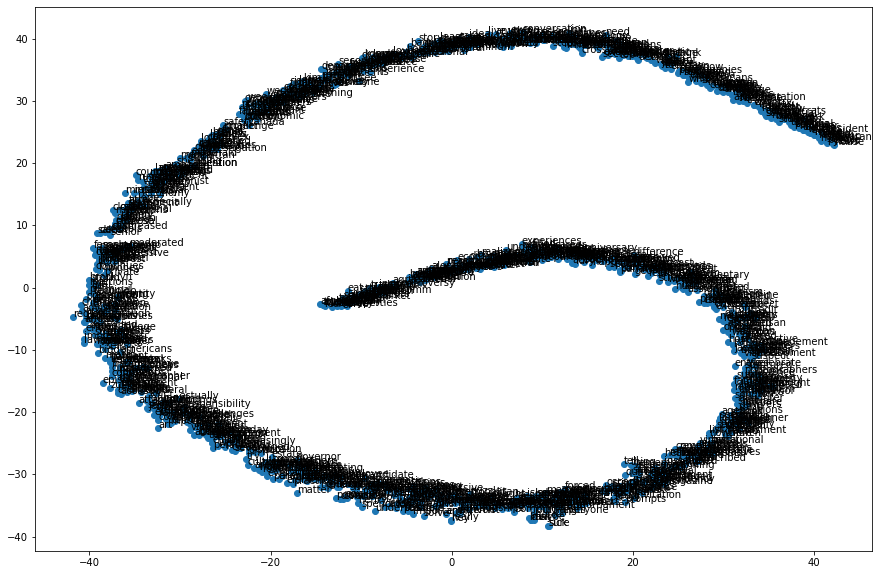

In [41]:
X = w2vnyt[terms_vocabulary]
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=terms_vocabulary, columns=['x', 'y'])
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()


Obtenemos los 10 términos similares al término 'president', que no sean stopwords, según el modelo Word2Vec. Utiliza el método <b>most_similar</b> de la clase Word2Vec, que veréis en <a>https://radimrehurek.com/gensim/models/word2vec.html</a> y en <a>https://stackoverflow.com/questions/50275623/difference-between-most-similar-and-similar-by-vector-in-gensim-word2vec</a>. El parámetro de las n palabras más similares es topn (e.g: topn = 50)

In [42]:
# con el argumento topn inicializado en más de 10, en concreto 100 se obtiene los términos
# despues añadimos solo los que no se encuentran en stopwords ni signos.
# Finalmente de la lista resultante mostramos los 10 similares
term = 'president'
sims = w2vnyt.most_similar(term, topn=100)
result_terms = [sims[w] for w in range(0, len(sims)) if sims[w][0] not in stopwords and re.match("^[a-z]+.*", sims[w][0])]

pd.DataFrame(list(result_terms[:10]), columns=['term','distance'])

<ipython-input-42-d8edb6a5d493>:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  sims = w2vnyt.most_similar(term, topn=100)


,term,distance
0,trump,0.999330
1,mr.,0.999158
2,affair,0.998479
3,campaign,0.998445
4,white,0.998417
5,administration,0.998349
6,counsel,0.998313
7,xi,0.998266
8,north,0.998253
9,leader,0.998253


También mostramos los terminos con el método similarity

In [43]:
# just test and how to plot different 10 best
w2v_tuples = []

feature_names = terms_vocabulary

#Para cada feature name, calculamos su distancia respecto al término de referencia con el método model.similarity.
#Si la distancia es superior a 0, la tupla se pone en la lista de tuplas
for i in range(0, len(feature_names)):
    if feature_names[i] != term and w2vnyt.similarity(term, feature_names[i]) > 0:
        w2v_tuples.append((feature_names[i], w2vnyt.similarity(term, feature_names[i])))
    
#Se ordenan las tuplas
w2v_sorted_tuples = sorted(w2v_tuples, key=lambda tup: tup[1], reverse=True)

pd.DataFrame(list(w2v_sorted_tuples[:10:]), columns=['term','distance'])

<ipython-input-43-bc13f25c4d78>:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if feature_names[i] != term and w2vnyt.similarity(term, feature_names[i]) > 0:
<ipython-input-43-bc13f25c4d78>:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  w2v_tuples.append((feature_names[i], w2vnyt.similarity(term, feature_names[i])))


,term,distance
0,trump,0.999330
1,mr.,0.999158
2,affair,0.998479
3,campaign,0.998445
4,white,0.998417
5,administration,0.998349
6,counsel,0.998313
7,xi,0.998266
8,north,0.998253
9,leader,0.998253


Cargamos un modelo w2vec pre-entrenado: </ul>

Cargamos un modelo Word2Vec entrenado previamente con todo el Google News dataset, con aproximadamente cien mil millones de palabras. <b>Atención: ¡el modelo ocupa casi 2 GB! y la carga puede tardar unos minutos.</b>

In [44]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

Obtenemos los términos similares al término 'president' según el modelo pre-entrenado, que no sean stopwords. Como en el punto 7, utilizamos el método <b>most_similar</b>

In [45]:
sims = wv.most_similar(term, topn=100)
result_terms = [sims[w] for w in range(0, len(sims)) if sims[w][0] not in stopwords and re.match("^[a-z]+.*", sims[w][0])]

pd.DataFrame(list(result_terms[:10]), columns=['term','distance'])

,term,distance
0,chairman,0.670874
1,vice_president,0.670023
2,chief_executive,0.669127
3,pesident,0.626521
4,executive,0.618248
5,prez,0.576191
6,vicepresident,0.567255
7,presidents,0.559636
8,chairperson,0.555838
9,chief,0.550743


A partir del modelo de Google News,  se demuestra el sentido de la palabra 'apple' comprobando las palabras con las cuales comparte contexto

¿Es posible vincular un apple con Steve Jobs?

In [46]:
term_apple = "apple"
sims = wv.most_similar(term_apple, topn=100)
result_terms = [sims[w] for w in range(0, len(sims)) if sims[w][0] not in stopwords and re.match("^[a-z]+.*", sims[w][0])]

pd.DataFrame(list(result_terms[:10]), columns=['term','distance'])

,term,distance
0,apples,0.720360
1,pear,0.645070
2,fruit,0.641015
3,berry,0.630230
4,pears,0.613396
5,strawberry,0.605826
6,peach,0.602587
7,potato,0.596093
8,grape,0.593586
9,blueberry,0.586667


Si miramos los términos similares de la palabra apple esta muy relacionados los resultados con la fruta y no con Apple, el método most_similar tiene dos argumentos en concreto dos listas con valores positivos y negativos. En los positivos podremos incluir sinónimos de Apple, por ejemplo "computers", "founder" lo que es Steve jobs mientras que en los negativos pondremos las frutas ya que no queremos estas como relación.

In [47]:
term_apple = "apple"
sims = wv.most_similar(positive=["apple", "computer", "founder", "iphone"], negative=["fruit"])
pd.DataFrame(list(sims), columns=['term','distance'])

,term,distance
0,iPhone,0.581832
1,Iphone,0.566979
2,HyperCard,0.561142
3,Ipod_Touch,0.561122
4,Apple_IIe,0.558276
5,ipod,0.553949
6,ipod_touch,0.549559
7,ipad,0.545539
8,Ipad,0.543395
9,Jef_Raskin,0.543322


## 2. Obtención de datos a partir de recursos externos al texto

En este apartado obtendremos datos de similitud semántica con los recursos <b>Wordnet</b> y <b>ConceptNet</b>

### 2.1 WordNet


Accederemos a Wordnet a través de la librería nltk.

In [48]:
from nltk.corpus import wordnet as wn

El método de wordnet wup_similarity utiliza la métrica de similitud definida por la Wu and Palmer score en que el score (valor) depende de la distancia entre términos dentro del grafo de jerarquías de la ontología, que es el grafo que relaciona términos con sus hiperónimos e hipónimos.

Además de la distancia entre dos nodos a través del grafo, la distancia también tiene en cuenta el nivel de jerarquía (más abstracto o menos abstracto), asignando más similitud entre nodos de niveles más bajos (menos abstracto) que entre nodos de niveles más altos (más abstracto).

Comprobaremos que efectivamente la similitud de Wu and Palmer tiene el comportamiento esperado comparando las distancias entre pares de sinónimos en diferentes niveles de jerarquía (e.g. person vs human y kid vs child) y entre un término con un hipónimo y un hiperónimo (e.g: chair y table vs furniture).

In [49]:
person = wn.synset('person.n.01')
human = wn.synset('human.n.01')
print("LA DIST SEMÁNTICA ENTRE 'person' Y 'human' ES", person.wup_similarity(human))

LA DIST SEMÁNTICA ENTRE 'person' Y 'human' ES 0.5714285714285714


In [50]:
person in human.hypernyms()

False

In [51]:
kid = wn.synset('kid.n.01')
child = wn.synset('child.n.01')
print("LA DIST SEMÁNTICA ENTRE 'kid' Y 'child' ES", kid.wup_similarity(child))

LA DIST SEMÁNTICA ENTRE 'kid' Y 'child' ES 1.0


In [52]:
table = wn.synset('table.n.01')
furniture = wn.synset('furniture.n.01')
print("LA DIST SEMÁNTICA ENTRE 'furniture' Y 'table' ES", table.wup_similarity(furniture))

LA DIST SEMÁNTICA ENTRE 'furniture' Y 'table' ES 0.14285714285714285


In [53]:
tables = wn.synset('table.n.01')
furniture = wn.synset('furniture.n.01')

In [54]:
chair = wn.synset('chair.n.01')
# print(chair.definition())
print(chair in furniture.hypernyms())
print(chair in tables.hypernyms())

False
False


In [55]:
hypournitures = set([i for i in furniture.closure(lambda s:s.hyponyms())])
chair in hypournitures

True

In [56]:
chair = wn.synset('chair.n.01')
chair.hypernyms()

[Synset('seat.n.03')]

In [57]:
# import nltk.corpus as corpus
# import itertools as IT
# wordnet = corpus.wordnet
# list1 = ["chair"]
# list2 = ["table", "furniture"]
# for word1, word2 in IT.product(list1, list2):
#     wordFromList1 = wn.synsets(word1)[0]
#     wordFromList2 = wn.synsets(word2)[0]
#     print('{w1}, {w2}: {s}'.format(w1 = wordFromList1.name,
#                                    w2 = wordFromList2.name,
#                                     s = wordFromList1.wup_similarity(wordFromList2)))

Se ha mostrado como comparar synsets, se entiende que se puede usar las palabras del enuniciado. En el código se muestra chair esta en los hiperónimos de furnitures. Además se muestra las distancias de las palabras del enunciado.

### 2.2 ConceptNet

A partir de la relación IsA de ConceptNet (http://api.conceptnet.io/r/IsA) extraemos hiperónimos de los términos que hemos utilizado en el punto anterior y comparamos sus distancias con los extraidos por WordNet. Exploramos también casos de phrases como 'United States' que con WordNet no se pueden explorar.

In [58]:
import requests

In [59]:
obj = requests.get('http://api.conceptnet.io/related/c/en/person?filter=/c/en/human').json()
print("LA DISTANCIA SEMÁNTICA ENTRE 'person' Y 'human' SEGÚN CONCEPTNET ES ", \
      obj['related'][0]['weight'])

LA DISTANCIA SEMÁNTICA ENTRE 'person' Y 'human' SEGÚN CONCEPTNET ES  0.261


In [60]:
obj = requests.get('http://api.conceptnet.io/related/c/en/kid?filter=/c/en/child').json()
print("LA DISTANCIA SEMÁNTICA ENTRE 'kid' Y 'child' SEGÚN CONCEPTNET ES ", \
      obj['related'][0]['weight'])

LA DISTANCIA SEMÁNTICA ENTRE 'kid' Y 'child' SEGÚN CONCEPTNET ES  0.693


In [61]:
obj = requests.get('http://api.conceptnet.io/related/c/en/table?filter=/c/en/furniture').json()
print("LA DISTANCIA SEMÁNTICA ENTRE 'table' Y 'furniture' SEGÚN CONCEPTNET ES ", \
      obj['related'][0]['weight'])

LA DISTANCIA SEMÁNTICA ENTRE 'table' Y 'furniture' SEGÚN CONCEPTNET ES  0.332


Wornet está orientada para categarizar lógicamente y determinar similitud de palabras, mientras que ConcepNet esta diseñada para realizar inferencias prácticas basadas en el contexto sobre textos del mundo real. ConceptNet amplía la idea de WordNet de un nodo en la red semántica desde elementos puramente léxicos para incluir conceptos de order superior.



## 3. Interpretación de los datos: detección de temas.

En este apartado exploraremos cómo detectar temas en los documentos. Primero veremos cómo el clustering de las keywords de las noticias perfilan los temas. Utilizaremos el método de K-means, vectorizando las keywords con un vectorizador tf.idf.

En primer lugar, recogemos, para cada noticia, una lista de sus keywords.

In [62]:
df = pd.read_csv(article_file)
keywords_lists = df.keywords.tolist() #lista de keywords por noticia

keywords_lists = list(map(lambda x: list(map(lambda y: y.strip(' \'[]\''), x.split(','))), keywords_lists))

keywords_lists[:3]

[['Bitcoin (Currency)',
  'Electric Light and Power',
  'United States Economy',
  'Labor and Jobs',
  'Productivity'],
 ['United States Defense and Military Forces',
  'North Korea',
  'United States International Relations',
  'United States Politics and Government',
  'Embargoes and Sanctions',
  'Civilian Casualties',
  'Defense Department',
  'Joint Chiefs of Staff'],
 ['Trump',
  'Donald J',
  'Curiel',
  'Gonzalo P',
  'United States Politics and Government',
  'Decisions and Verdicts',
  'Courts and the Judiciary',
  'Mexico',
  'Border Barriers']]

Convertimos cada lista de keywords en una cadena de palabras; es decir, en un documento

In [63]:
keywords_docs = [" ".join(l) for l in keywords_lists ]

print(keywords_docs[:3])

['Bitcoin (Currency) Electric Light and Power United States Economy Labor and Jobs Productivity', 'United States Defense and Military Forces North Korea United States International Relations United States Politics and Government Embargoes and Sanctions Civilian Casualties Defense Department Joint Chiefs of Staff', 'Trump Donald J Curiel Gonzalo P United States Politics and Government Decisions and Verdicts Courts and the Judiciary Mexico Border Barriers']


### 3.1 K-means

Clusterizamos las keywords en 4 clusters

Vectorizamos los documentos con un tf.idf vectorizer, que tiene 'word' como tokenizador

In [64]:
# tfidf_vectorizer = TfidfVectorizer(analyzer="word") ## word is in default constructor
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(keywords_docs)

In [65]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters, n_init=10) 
km.fit(tfidf)
labels = km.labels_.tolist()

In [66]:
#example
# print(keywords_docs[0:2])
# print(km.predict(tfidf_vectorizer.transform(keywords_docs))[0:2])

Vemos las keywords en 4 clusters. Ten en cuenta que, en el paso anterior, los vectores ya están en una matriz

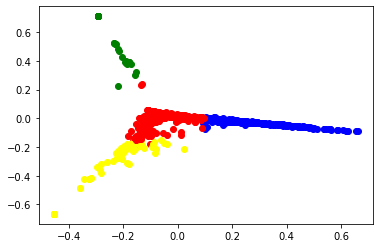

In [67]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
x = tfidf.todense()
reduced_data = PCA(n_components=2).fit_transform(x)

labels_color_map = {0: 'yellow', 1: 'red' , 2: 'blue', 3 : 'green'}

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):        
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1,pca_comp_2, c=color)
plt.show()

La gráfica es suficientemente clara, pero hay algunos clusters que están visualmente bien definidos. Si aumentamos el número de clusters empeoaría la visión.

### 3.2 LDA

Aplicación del método LDA para extraer temas de documentos

Utilizando el método LDA, extrae temas a partir de los conjuntos de keywords de las noticias. Experimentaremos con el parámetro num_topics hasta encontrar un conjunto de temas que encuentres informativo, y asignaremos nombres a los temas encontrados. La construcción del modelo LDA puede tardar más de 10 minutos para algunos casos.

Preparamos, por cada noticia, la lista de sus keywords (keywords lists). Ver introducción apartado 3.

Cargamos el módulo necesario para utilizar el método LDA.

In [68]:
import gensim.corpora as corpora

def lda(terms):
    dictionary = corpora.Dictionary(terms)

    texts = terms

    corpus = [dictionary.doc2bow(text) for text in texts]

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                               num_topics=10, 
                                               random_state=1,
                                               id2word = dictionary, 
                                               passes=500)

    return ldamodel



Partiendo de la función LDA anterior explora modelos de temas a partir de la lista de keywords de las noticias. Utiliza diferentes valores para el campo num_topics.

In [69]:
def lda_modi(terms, num_topics):
    dictionary = corpora.Dictionary(terms)

    texts = terms

    corpus = [dictionary.doc2bow(text) for text in texts]

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                               num_topics=num_topics, 
                                               random_state=1,
                                               id2word = dictionary, 
                                               passes=500)

    return ldamodel


In [70]:
# ldamodels = []
# for i in range (5, 15):
#     ldamodels.append(lda_modi(keywords_lists, i))

In [71]:
ldamodel = lda_modi(keywords_lists, 7)

In [72]:
ldamodel1 = lda_modi(keywords_lists, 10)

In [73]:
ldamodel2 = lda_modi(keywords_lists, 15)

In [74]:
#Visualización del LDA
#Librería para crear matrices
import numpy as np

import pandas as pd
from IPython.display import display, HTML

# Matriz donde se muestran los diez términos del vocabulario más probables de pertenecer a un topic.
K = ldamodel.num_topics
print(K)
topicWordProbMat = ldamodel.print_topics(num_topics=K, num_words=10)
print(topicWordProbMat)

7
[(0, '0.016*"Facebook Inc" + 0.015*"Social Media" + 0.013*"Presidential Election of 2016" + 0.010*"Cambridge Analytica" + 0.010*"Politics and Government" + 0.009*"Data-Mining and Database Marketing" + 0.009*"United States Politics and Government" + 0.007*"United States" + 0.006*"Women and Girls" + 0.006*"Zuckerberg"'), (1, '0.024*"Gun Control" + 0.017*"Fla" + 0.017*"School Shootings and Armed Attacks" + 0.016*"Parkland" + 0.016*"Shooting (2018)" + 0.013*"Demonstrations" + 0.013*"Protests and Riots" + 0.010*"Politics and Government" + 0.007*"National Rifle Assn" + 0.006*"Firearms"'), (2, '0.031*"New York City" + 0.024*"Television" + 0.012*"Vietnam War" + 0.007*"Diet and Nutrition" + 0.006*"Vietnam" + 0.006*"NCAA Basketball Championships (Men)" + 0.006*"Photography" + 0.006*"Bill" + 0.005*"Cooking and Cookbooks" + 0.005*"de Blasio"'), (3, '0.067*"" + 0.022*"New York Times" + 0.014*"Photography" + 0.009*"Race and Ethnicity" + 0.009*"News and News Media" + 0.008*"Reading and Writing Skil

In [75]:
# Matriz donde se muestran los diez términos del vocabulario más probables de pertenecer a un topic.
K = ldamodel1.num_topics
print(K)
topicWordProbMat = ldamodel1.print_topics(num_topics=K, num_words=10)
print(topicWordProbMat)

10
[(0, '0.012*"United States" + 0.012*"NY)" + 0.008*"Television" + 0.006*"Krim" + 0.006*"War Crimes" + 0.006*"Genocide and Crimes Against Humanity" + 0.006*"Blacks" + 0.006*"Politics and Government" + 0.005*"Real Estate and Housing (Residential)" + 0.005*"Travel and Vacations"'), (1, '0.039*"Trump" + 0.036*"Donald J" + 0.022*"United States International Relations" + 0.019*"United States Politics and Government" + 0.014*"Politics and Government" + 0.012*"Clifford" + 0.011*"Jimmy" + 0.010*"Adultery" + 0.010*"Stephanie (1979- )" + 0.010*"Russia"'), (2, '0.021*"Television" + 0.009*"NCAA Basketball Championships (Men)" + 0.008*"Photography" + 0.007*"Heart" + 0.007*"Basketball (College)" + 0.007*"Theater" + 0.007*"Real Estate and Housing (Residential)" + 0.006*"Exercise" + 0.006*"Weight" + 0.006*"Diet and Nutrition"'), (3, '0.063*"" + 0.053*"International Trade and World Market" + 0.039*"Donald J" + 0.039*"Trump" + 0.035*"Customs (Tariff)" + 0.026*"United States Politics and Government" + 0

In [76]:
# Matriz donde se muestran los diez términos del vocabulario más probables de pertenecer a un topic.
K = ldamodel2.num_topics
print(K)
topicWordProbMat = ldamodel2.print_topics(num_topics=K, num_words=10)
print(topicWordProbMat)

15
[(0, '0.010*"Krim" + 0.008*"Art" + 0.007*"Europe" + 0.006*"Supreme Court (US)" + 0.006*"NY)" + 0.006*"Politics and Government" + 0.005*"Kennedy" + 0.005*"Scalia" + 0.005*"Antonin" + 0.005*"Samuel A Jr"'), (1, '0.020*"Politics and Government" + 0.009*"Academy Awards (Oscars)" + 0.009*"United States International Relations" + 0.008*"Regulation and Deregulation of Industry" + 0.007*"Helicopters" + 0.007*"Arms Control and Limitation and Disarmament" + 0.007*"Putin" + 0.007*"Vladimir V" + 0.006*"Aviation Accidents" + 0.006*"Safety and Disasters"'), (2, '0.020*"Vietnam War" + 0.015*"Television" + 0.013*"Vietnam" + 0.012*"Xi Jinping" + 0.011*"Politics and Government" + 0.010*"Exercise" + 0.010*"China" + 0.009*"Weight" + 0.007*"Photography" + 0.007*"Roman Catholic Church"'), (3, '0.032*"Photography" + 0.030*"Cooking and Cookbooks" + 0.025*"New York Times" + 0.011*"Italy)" + 0.011*"Recipes" + 0.009*"Quebec Province (Canada)" + 0.009*"Wines" + 0.009*"Canada" + 0.008*"Montreal (Quebec)" + 0.00

## 4. Predicciones

La empresa S&S hizo la clasificación de los titulares TOP y NOTOP con titulares del New York Times durante la época Trump. Aquí comprobaremos si el clasificador es útil para clasificar titulares publicados ya en la era Biden. 


Creamos un modelo de clasificación de titulares a partir de los titulares del fichero 'NYT-Comment-Headlines.csv'

Preparamos los titulares y las etiquetas TOP y NOTOP para emparejarlos para hacer el entrenamiento

In [77]:
import pandas as pd

ny_headlines_file = os.path.join(data_dir, "NYT-Comment-Headlines.csv")
df = pd.read_csv(ny_headlines_file, sep='\t')

data_headlines = []
data_labels = []

headlines = df['Headline'].tolist()
tags = df['Tag'].tolist()

for i in range(len(headlines)): 
    data_headlines.append(headlines[i]) 
    data_labels.append(tags[i])

Volvemos a entrenar un modelo de predicción para TOP o NO TOP a partir de la vectorización TfIdf de los titulares. Utiliza los términos detectados por el modelo de detección de phrases.

Cargamos las librerías necesarias para el entrenamiento y la utilización del modelo. Además, cargamos el modelo de detección de phrases.


In [78]:
import numpy as np
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from gensim.models.phrases import Phrases

model_phrases = Phrases.load('model_phrases')

FileNotFoundError: [Errno 2] No such file or directory: 'model_phrases'

Se construye los vectores TfIdf de los titulares, utilizando como términos las phrases detectadas.

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
#1. Encontramos los phrases que ya ha aprendido a detectar en cada titular y seleccionamos los que son términos

def unify(l):
    term_unified = l
    if l == 'mr._trump' or l == 'donald trump':
        term_unified = 'trump'
    elif l == 'dpt':
        term_unified = 'department'
    return term_unified

def wnlemmatize(t,postag):
    lemma = ""
    #Definición del lematizador
    lem = WordNetLemmatizer()
    #Si el candidato es monopalabra, se obtiene el lema con el lematizador de WordNet según su PoS
    if ' ' not in t:
        lemma = lem.lemmatize(t,get_wn_pos(postag[0][1]))
    #Si el candidato es multipalabra, obtenemos su lema como si fuera un nombre, aplicando el lematizador de WordNet
    else:
        lemma = lem.lemmatize(t,'n')
    return lemma

def get_wn_pos(pos):
    if re.match(r'^N',pos):
        wn_pos = 'n'
    elif re.match(r'^V',pos):
        wn_pos = 'v'
    else:
        wn_pos = 'n' #En inglés, los lemas de términos que no son verbos ni nombres se obtienen como si fueran
                        #nombres
    return wn_pos

def transform_sentence(sentence):
    sentence_terms = phrases[word_tokenize(sentence.lower())]
    #Despojamos los signos de puntuación de los términos
    stripped_candidates = [st.strip('".,;:-():!?-‘’_') for st in sentence_terms]
    #Unificamos los términos
    terms_unified = [unify(sc).lstrip(' ') for sc in stripped_candidates] #(ver 3.3)
    #Lematizamos los términos con el lematizador de Wordnet
    terms_lemmatized_and_unified = [wnlemmatize(ut,nltk.pos_tag(word_tokenize(ut))).replace(' ', '_') \
                                    for ut in terms_unified \
                                    if good_candidate(ut,nltk.pos_tag(word_tokenize(ut))) == True] #(ver 3.3)
#     return terms_lemmatized_and_unified
    return terms_unified

terms_stream = [transform_sentence(dt) for dt in data_headlines]

#2. Convertimos la lista de términos de cada titular en un documento y lo añadimos a la colección

documents = [" ".join(ts) for ts in terms_stream]

print(documents[:10])

#3. Vectorización de los titulares
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizerNYT = TfidfVectorizer(analyzer= 'word', stop_words=stopwords)
X = vectorizerNYT.fit_transform(documents)
#Matriz con los vectores
MNYT = X.toarray()

#Obtenemos los feature names
feature_names = np.array(vectorizerNYT.get_feature_names())
#print(feature_names)
print(MNYT)

Se entrena el modelo clasificador utilizando Logistic Regression.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
        MNYT, 
        data_labels,     
        train_size=0.80,
        random_state=123)

In [ ]:
#2. Importar clasificador
from sklearn.linear_model import LogisticRegression

#Establecemos el método de clasificación (método logistic regression)
classifier = LogisticRegression()
#Entrenamiento del clasificador aplicando el método al corpus de entrenamiento
log_model = classifier.fit(X=X_train, y=y_train)

Tomamos diez titulares actuales de la sección de política del New York Times. Y Comprobamos si el clasificador funciona para estos titulares.

Utilizamos el modelo entrenado para predecir la categoría TOP o NO TOP de los titulares del New York Times que has escogido. Ver las palabras más informativas para cada clase (TOP y NO TOP).

In [ ]:
y_pred = log_model.predict(X_test)

print("\nCLASES TOP/NONTOP DEL CORPUS DE TEST:\n===============")

print(y_pred)

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

print("\nFEATURES MÁS INFORMATIVOS EN LOS TITULARES TOP Y NO TOP:\n===============")

print(most_informative_feature_for_binary_classification(vectorizerNYT, classifier))